# Who is being left out by public transport?
**An analysis on public transport quality and accessibility in Santiago, Chile**  
<a href="https://iacopogarizio.com" target="_blank"><b>Iacopo Garizio</b></a>

### Summary
This notebook uses census information and GTFS data to analyze public transport quality and accessibility to find underserved communities in Santiago, Chile. The findings show different results depending on the metric used. However, no matter the metric, the outskirts are always worse off than other areas.

**Sections**
1. [Simulating the population in each city block](#1.-Simulating-the-population-in-each-city-block)
2. [Processing GTFS data](#2.-Processing-GTFS-data)
3. [Finding the nearest stops/stations to each simulated person](#3.-Finding-the-nearest-stops/stations-to-each-simulated-person)
4. [Calculating accessibility and quality metrics](#4.-Calculating-accessibility-and-quality-metrics)
5. [Plotting the results](#5.-Plotting-the-results)
6. [Findings](#6.-Findings)
7. [Discussion](#7.-Discussion)
8. [Conclusion](#8.-Conclusion)

___

### Imports

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.colors as colors

import random
import zipfile

### Global definitions

In [2]:
# Defining a bounding box around Santiago. This will be used throughout the code.
BOX_POLY = box(-70.82, -33.645, -70.47, -33.3)
box_gdf = gpd.GeoDataFrame({'geometry': [BOX_POLY]}, crs="EPSG:4326")

## 1. Simulating the population in each city block

### 1.1 Loading census data

In [3]:
blocks = gpd.read_file("zip://./data/chile_city_blocks.zip")
blocks.to_crs("EPSG:4326", inplace=True)

blocks = blocks[blocks.REGION == 'REGIÓN METROPOLITANA DE SANTIAGO'].copy()
blocks = gpd.overlay(blocks, box_gdf)

### 1.2 Performing the simulation
Because the census data has only information at a city block level, I simulate the position of each person inside each city block (keeping a margin from the border of the block). The points are uniformly distributed.

In [4]:
def generate_random_points(polygon, n):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    while len(points) < n:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
    
    return points

def concat_gdf_list(gdf_list):
    crs = gdf_list[0].crs
    concat_df = pd.concat(random_points_list, ignore_index=True)
    return gpd.GeoDataFrame(concat_df, crs=crs)

In [5]:
SCALE_FACTOR = 0.9 # This is used to scale each block to generate the outer gap

blocks['scaled_geometry'] = blocks.scale(SCALE_FACTOR, SCALE_FACTOR, SCALE_FACTOR)
random_points_list = []

for block in blocks.itertuples():
    random_points = generate_random_points(block.scaled_geometry, block.TOTAL_PERS)
    gdf_random_points = gpd.GeoDataFrame(geometry=random_points, crs="EPSG:4326")
    gdf_random_points['FID'] = block.FID
    
    random_points_list.append(gdf_random_points)

random_population = concat_gdf_list(random_points_list)
random_population.index.name = 'person_id'

In [6]:
# FID corresponds to the ID of each city block.
random_population.sample(5)

geometry    FID
person_id                                    
1952984    POINT (-70.64403 -33.57619)  12877
1548410    POINT (-70.56412 -33.53716)   9879
3338962    POINT (-70.60003 -33.44822)  22771
781177     POINT (-70.66828 -33.39933)   4537
3918875    POINT (-70.58343 -33.50142)  25983

### 1.3 Understanding the randomization
Here we can see the randomization inside a selected city block and a selected commune.

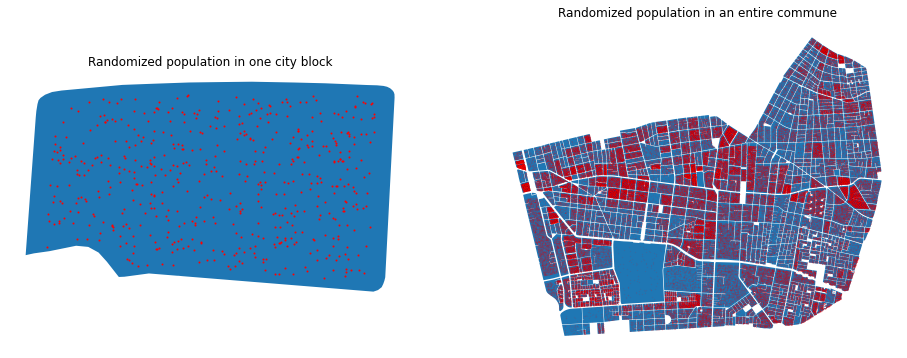

In [7]:
SEL_COMMUNE = "ÑUÑOA"
SEL_BLOCK_FID = 24146

block_example = blocks[blocks.FID == SEL_BLOCK_FID]
random_population_block_example = random_population[random_population.FID == SEL_BLOCK_FID]
commune_example = blocks[blocks.COMUNA == SEL_COMMUNE]
random_population_commune_example = random_population[random_population.FID.isin(commune_example.FID)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

block_example.plot(ax=ax1)
random_population_block_example.plot(ax=ax1, markersize=1, color='r')

commune_example.plot(ax=ax2)
random_population_commune_example.plot(ax=ax2, markersize=0.001, color='r')

ax1.set_title("Randomized population in one city block")
ax2.set_title("Randomized population in an entire commune")

ax1.axis('off')
ax2.axis('off')
plt.show()

___

## 2. Processing GTFS data

### 2.1 Loading Santiago's GTFS data

In [8]:
zf = zipfile.ZipFile("./data/santiago_gtfs.zip")

stops_df = pd.read_csv(zf.open('stops.txt'))
trips_df = pd.read_csv(zf.open('trips.txt'))
stop_times_df = pd.read_csv(zf.open('stop_times.txt'))

### 2.2 Processing the data
The code keeps the trips that occur only in working days (by doing "service_id == 'L'"). It then uses this information to keep the matching stop_times (this means that we will only get stop_times that happen on working days). The code then counts the number of buses and the number of unique routes that pass through each stop. These two measures are going to be used as a proxy for quality, where a higher number of buses or routes imply better quality.

In [9]:
trips_working_day = trips_df[trips_df.service_id == 'L'].copy()
trips_working_day_id = trips_working_day.trip_id.unique()

stop_times_df_working_day = stop_times_df[stop_times_df.trip_id.isin(trips_working_day_id)].copy()
stop_n_buses = stop_times_df_working_day.groupby('stop_id').size().reset_index(name="n_buses")

stop_trips = pd.merge(trips_working_day, stop_times_df_working_day, on='trip_id', how='left')
stop_routes = stop_trips.groupby('stop_id').route_id.apply(set).reset_index(name="routes")

stops_df = pd.merge(stops_df, stop_n_buses, on='stop_id', how='left')
stops_df = pd.merge(stops_df, stop_routes, on='stop_id', how='left')

stops_df.n_buses.fillna(0, inplace=True)  # Some stops in the GTFS don't have buses running through.
stops_df['routes'] = stops_df.routes.apply(lambda d: d if pd.notnull(d) else set())  # Can't do fillna(set()) directly.

### 2.3 Converting the stops data into a GeoDataFrame and filtering it

In [10]:
stops_geometry = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)
stops = gpd.GeoDataFrame(stops_df, geometry=stops_geometry, crs='EPSG:4326')
stops.drop(columns=['stop_code', 'stop_lat', 'stop_lon', 'stop_url'], inplace=True)

stgo = blocks.to_crs("EPSG:3857").buffer(100).to_crs("EPSG:4326").unary_union
stops = stops[stops.within(stgo)].copy()  # Keeps all stops inside the parts of the city we're interested in.

___

## 3. Finding the nearest stops/stations to each simulated person
For this process, I load the stops' locations into a kd-tree and find the k nearest stops for each simulated point. I then calculate a haversine distance between each point and each of the nearest stops.

### 3.1 Creating functions to find nearest points and calculate distances

In [11]:
def haversine_distance(point_1, point_2):
    """
    Reference: https://stackoverflow.com/a/29546836/7657658
    """
    lon1, lat1 = point_1.x.values, point_1.y.values
    lon2, lat2 = point_2.x.values, point_2.y.values
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km


def get_nearest_stops(points, stops, k):
    points = points.copy()
    stops = stops.copy()
    points_coordinates = list(zip(points.geometry.x, points.geometry.y))
    stops_coordinates = list(zip(stops.geometry.x, stops.geometry.y))
    btree = cKDTree(stops_coordinates)
    if k != 1:
        dist, idx = btree.query(points_coordinates, n_jobs=-1, k=k)
    else:
        dist, idx = btree.query(points_coordinates, n_jobs=-1, k=[1])  # Prevents dimentional squeeze

    points_nearest_stops_dfs = []

    for k_i in range(k):
        stops_close_ki = stops.iloc[idx[:,k_i]].reset_index(drop=True).copy()
        stops_close_ki.rename(columns={'geometry': 'stop_geometry'}, inplace=True)
        points_nearest_stops = pd.concat([points.reset_index(), stops_close_ki], axis=1)

        points_nearest_stops['distance_rank'] = k_i
        points_nearest_stops['distance_km'] = haversine_distance(points_nearest_stops.stop_geometry, points_nearest_stops.geometry)
        points_nearest_stops_dfs.append(points_nearest_stops)

    return pd.concat(points_nearest_stops_dfs).reset_index(drop=True)

### 3.2 Obtaining the nearest 10 stops for each person

In [12]:
pop_nearests_k_stops = get_nearest_stops(random_population, stops, k=10)

In [13]:
pop_nearests_k_stops.sample(5)

person_id                     geometry    FID stop_id  \
37712592     808746  POINT (-70.65554 -33.54869)   4722   PG957   
25066165     463601  POINT (-70.66011 -33.45559)   1878    PA36   
37562557     658711  POINT (-70.68896 -33.36880)   3490  PB1384   
24057921    5605998  POINT (-70.55671 -33.58229)  43611   PF279   
27519761    2917197  POINT (-70.75615 -33.48868)  19035  PI1508   

                                               stop_name  n_buses  \
37712592          PG957-Nueva Oriente / Esq. Torreblanca     18.0   
25066165            PA36-Manuel Rodríguez / Esq. Domeyko     31.0   
37562557                PB1384-Huechuraba / Esq. Granada      9.0   
24057921  PF279-Las Nieves Oriente / Esq. Los Salesianos     18.0   
27519761           PI1508-Volcán Maipo / Esq. El Manzano      9.0   

                             routes                stop_geometry  \
37712592                {G08, G08v}  POINT (-70.65317 -33.54736)   
25066165  {113, 510, 115, 125, 302}  POINT (-70.65844 -33.45477)   
37562557                      {B19}  POINT (-70.68680 -33.36766)   
24057921                 {F05, F07}  POINT (-70.55810 -33.58272)   
27519761                      {I22}  POINT (-70.75315 -33.48769)   

          distance_rank  distance_km  
37712592              6     0.265252  
25066165              4     0.179605  
37562557              6     0.237308  
24057921              3     0.136939  
27519761              4     0.299260

___

## 4. Calculating accessibility and quality metrics
For each city block, this code calculates:
- Average distance to the nearest stop/station.
- Summed distance to the nearest stop/station.
- Average distance to the 10 nearest stops/stations.
- Average number of unique bus routes/Metro lines that run through stops within 900m of the person.
- Average number of buses/trains that run through stops within 900m of the person on a working day.

This information is then merged into a single DataFrame.

### 4.1 Ad-hoc function to merge sets of routes

In [193]:
def combine_unique_routes(routes):
     return set().union(*routes.values)

### 4.2 Computing the metrics

In [14]:
DIST_MAX = 0.9 # distance km

pop_nearest_stop = pop_nearests_k_stops[pop_nearests_k_stops.distance_rank == 0]
mean_dist_nearest = pop_nearest_stop.groupby('FID').distance_km.agg(mean_distance_nearest='mean', summed_distance_nearest='sum')

mean_dist_k_nearests = pop_nearests_k_stops.groupby('FID').distance_km.mean().to_frame(name="mean_distance_k_nearest")

pop_nearests_max_dist = pop_nearests_k_stops.copy()
farther_than_max = (pop_nearests_max_dist.distance_km > DIST_MAX)
pop_nearests_max_dist.loc[farther_than_max, 'n_buses'] = 0
pop_nearests_max_dist.loc[farther_than_max, 'routes'] = [set() for __ in range(farther_than_max.sum())]

n_buses_close = pop_nearests_max_dist.groupby(['FID', 'person_id'], as_index=False).n_buses.sum()
mean_n_buses_close = n_buses_close.groupby('FID').n_buses.mean().to_frame(name="mean_n_buses_close")

routes_close = pop_nearests_max_dist.groupby(['FID', 'person_id']).routes.apply(combine_unique_routes).reset_index(name="routes_close")
routes_close['n_routes'] = routes_close.routes_close.apply(len)
mean_n_routes_close = routes_close.groupby('FID').n_routes.mean().to_frame(name="mean_n_routes_close")

blocks_transit = blocks.copy()
blocks_transit = pd.merge(blocks_transit, mean_dist_nearest.reset_index(), on='FID', how='left')
blocks_transit = pd.merge(blocks_transit, mean_dist_k_nearests.reset_index(), on='FID', how='left')
blocks_transit = pd.merge(blocks_transit, mean_n_buses_close.reset_index(), on='FID', how='left')
blocks_transit = pd.merge(blocks_transit, mean_n_routes_close.reset_index(), on='FID', how='left')

blocks_transit['density'] = blocks_transit.TOTAL_PERS / blocks_transit.SHAPE_Area  # Useful extra metric.

### Filtering out city blocks

In [15]:
# blocks_transit_f corresponds to the *filtered* version of blocks_transit. Only keeps blocks with 10 or more people
blocks_transit_f = blocks_transit[blocks_transit.TOTAL_PERS >= 10].copy()

In [16]:
blocks_transit_f.sample(5)

FID    CUT                            REGION   PROVINCIA  \
38114  42585  13201  REGIÓN METROPOLITANA DE SANTIAGO  CORDILLERA   
42953  47895  13121  REGIÓN METROPOLITANA DE SANTIAGO    SANTIAGO   
9870    9871  13110  REGIÓN METROPOLITANA DE SANTIAGO    SANTIAGO   
35456  36312  13401  REGIÓN METROPOLITANA DE SANTIAGO       MAIPO   
37121  41357  13604  REGIÓN METROPOLITANA DE SANTIAGO   TALAGANTE   

                    COMUNA     NOMBRE_DIS  CODIGO_DIS       MANZENT  \
38114          PUENTE ALTO      LOS TOROS          12  1.320112e+13   
42953  PEDRO AGUIRRE CERDA        NAVIDAD           8  1.312108e+13   
9870            LA FLORIDA     SANTA INÉS           9  1.311009e+13   
35456         SAN BERNARDO      O'HIGGINS           1  1.340101e+13   
37121        PADRE HURTADO  PADRE HURTADO           3  1.360403e+13   

       ZONA_CENSA  MANZANA  ...   SHAPE_Leng    SHAPE_Area  \
38114           4        4  ...   247.844570   2451.810633   
42953           1       15  ...   244.974859   3581.263550   
9870            1       12  ...   299.572563   4954.278967   
35456           1       11  ...   354.835175   7354.340641   
37121           3       25  ...  1149.140625  23089.161547   

                                                geometry  \
38114  POLYGON ((-70.57623 -33.56439, -70.57712 -33.5...   
42953  POLYGON ((-70.68271 -33.50430, -70.68297 -33.5...   
9870   POLYGON ((-70.57025 -33.53672, -70.57113 -33.5...   
35456  POLYGON ((-70.70143 -33.58953, -70.70151 -33.5...   
37121  POLYGON ((-70.79765 -33.56730, -70.79744 -33.5...   

                                         scaled_geometry  \
38114  POLYGON ((-70.57627 -33.56439, -70.57708 -33.5...   
42953  POLYGON ((-70.68275 -33.50432, -70.68298 -33.5...   
9870   POLYGON ((-70.57030 -33.53672, -70.57109 -33.5...   
35456  POLYGON ((-70.70146 -33.58951, -70.70154 -33.5...   
37121  POLYGON ((-70.79769 -33.56739, -70.79750 -33.5...   

      mean_distance_nearest summed_distance_nearest mean_distance_k_nearest  \
38114              0.063256                3.668840                0.239048   
42953              0.138483                5.954762                0.225807   
9870               0.127090                5.846120                0.276133   
35456              0.083679                3.849253                0.233518   
37121              1.306942              328.042414                1.387379   

      mean_n_buses_close mean_n_routes_close   density  
38114         164.000000            6.000000  0.023656  
42953         230.441860            8.255814  0.012007  
9870          233.608696            7.000000  0.009285  
35456         356.086957           12.956522  0.006255  
37121           0.000000            0.000000  0.010871  

[5 rows x 66 columns]

___

## 5. Plotting the results

### 5.1 Loading communes shapefiles
This will be used as a reference in the graphs

In [17]:
communes = gpd.read_file("zip://./data/chile_communes.zip")
communes.to_crs("EPSG:4326", inplace=True)

communes = communes[communes.Region.isin(['Región Metropolitana de Santiago'])].copy()

### 5.2 Generating ad-hoc plots

In [18]:
def annotate_record(gdf_record, annotation_column, ax, annotation_outline_width):
    text = gdf_record[annotation_column]
    xy = gdf_record.geometry.representative_point().coords[0]
    path_effects = [pe.withStroke(linewidth=annotation_outline_width, foreground="white")]
    ax.annotate(text=text, xy=xy, path_effects=path_effects, ha='center')

    
def annotate_map(gdf, annotation_column, ax, annotation_outline_width):
    gdf.apply(lambda r: annotate_record(r, annotation_column, ax, annotation_outline_width=annotation_outline_width), axis=1)
    

def plot_blocks(gdf, color_column=None, vmin=None, vmax=None, plot_only_borders=False, linewidth=0.5, cmap='coolwarm', background_color=None, color=None, cbar_colors='black', figsize=(32, 16)):
    fig, ax = plt.subplots(1, figsize=figsize, facecolor=background_color)
    
    clipped_gdf = gdf.copy()
    if plot_only_borders:
        clipped_gdf['geometry'] = clipped_gdf.boundary
    
    clipped_gdf = gpd.overlay(clipped_gdf, box_gdf)
    clipped_gdf.plot(ax=ax, column=color_column, color=color, cmap=cmap, legend=True, vmin=vmin, vmax=vmax, linewidth=linewidth)
    
    if color_column is not None:
        cb_ax = fig.axes[1]
        cb_ax.tick_params(colors=cbar_colors)

    ax.axis('off')
    return ax


def plot_communes(communes_gdf, annotate_communes=True, annotation_column='Comuna', linewidth=0.5, background_color=None,
                  annotation_outline_width=3, color="#0f0f0f", ax=None, figsize=(32, 16)):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize, facecolor=background_color)
        
    clipped_communes = communes_gdf.copy()
    clipped_communes['geometry'] = gpd.clip(clipped_communes.boundary, box_gdf)
    clipped_communes.plot(ax=ax, color=color, linewidth=linewidth)
    
    if annotate_communes:
        overlayed_communes = gpd.overlay(communes_gdf, box_gdf, how='intersection')
        annotate_map(overlayed_communes, annotation_column, ax, annotation_outline_width)
    
    ax.axis('off')
    return ax

___

## 6. Findings

### 6.1 Average distance to the nearest bus stop/Metro station
The average person has to walk 188 meters to get to the nearest bus stop or Metro station, which translates into about 3 minutes walking (assuming a conservative speed of 1 m/s)\*. However, this number surpasses the 769 meters for the city blocks above the 98th percentile.  
On a general level, the counties in the outskirts of the city are the ones with the worst access to public transport. It is still important to note that in almost every commune there are patches of city blocks with low accessibility.  

\* It is important to notice that this would only hold if the path taken was a straight line. For most people, this path would not be so direct. To obtain an approximation for the real distance traveled, [some studies](https://www.sciencedirect.com/science/article/pii/S2352146514002294?via%3Dihub) have obtained a correction factor of around 1.35.

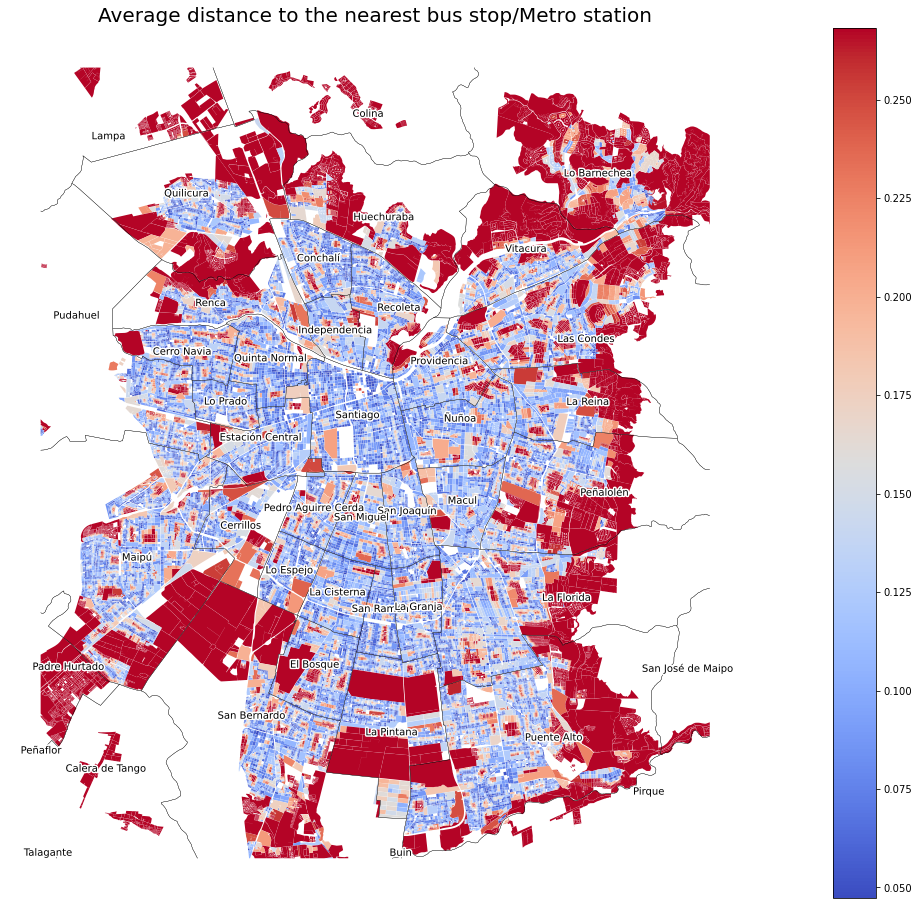

In [19]:
var_name = 'mean_distance_nearest'
vmin = blocks_transit_f[var_name].quantile(0.05)
vmax = blocks_transit_f[var_name].quantile(0.90)

ax = plot_blocks(blocks_transit_f, var_name, vmin, vmax, cmap='coolwarm')
ax = plot_communes(communes, annotate_communes=True, linewidth=0.3, ax=ax)
title = f"Average distance to the nearest bus stop/Metro station"
ax.set_title(title, {'fontsize': 20, 'color': 'black'})
plt.show()

Overall average: 0.188Km
98th percentile: 0.769Km


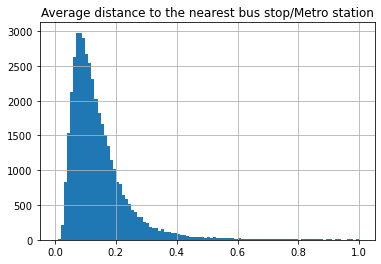

In [82]:
print(f"Overall average: {blocks_transit_f.mean_distance_nearest.mean():.3}Km")
print(f"98th percentile: {blocks_transit_f.mean_distance_nearest.quantile(0.98):.3}Km")
blocks_transit_f.mean_distance_nearest.hist(bins=100, range=(0,1))
plt.title("Histogram of the average distance to the nearest bus stop/Metro station")
plt.show()

### 6.2 Average distance to the nearest 10 bus stops/Metro stations
Following the same logic as before, the average user would have to walk 338 meters on average to reach the 10 nearest bus stops or Metro stations. The city blocs in the 90th percentile have to walk 419 meters. Similarly to the last graph, the outskirts of the city are the ones with the worst access and almost all communes show at least some blocks with low accessibility.

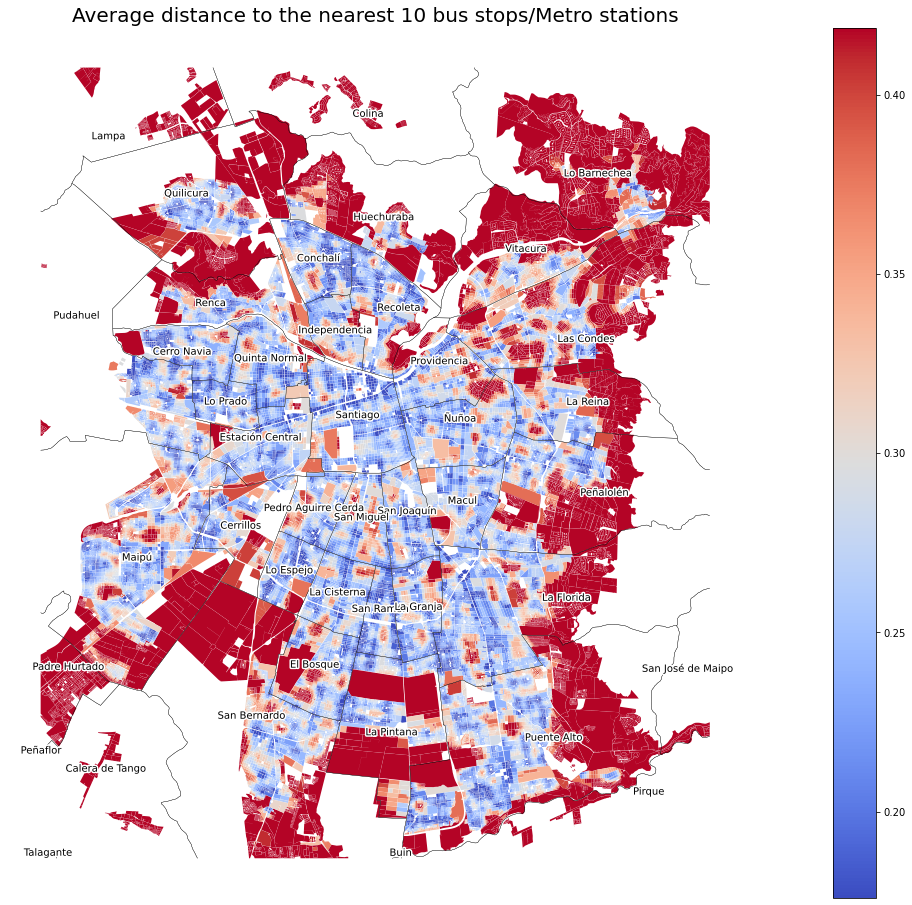

In [183]:
var_name = 'mean_distance_k_nearest'
vmin = blocks_transit_f[var_name].quantile(0.05)
vmax = blocks_transit_f[var_name].quantile(0.90)

ax = plot_blocks(blocks_transit_f, var_name, vmin, vmax, cmap='coolwarm')
ax = plot_communes(communes, annotate_communes=True, linewidth=0.3, ax=ax)
title = f"Average distance to the nearest 10 bus stops/Metro stations"
ax.set_title(title, {'fontsize': 20, 'color': 'black'})
plt.show()

Overall average: 0.338Km
Top 10%: 0.419Km


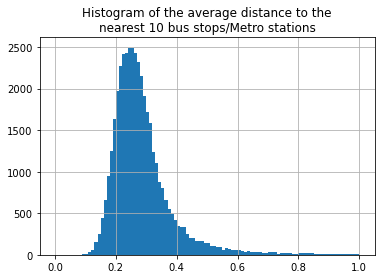

In [187]:
print(f"Overall average: {blocks_transit_f.mean_distance_k_nearest.mean():.3}Km")
print(f"Top 10%: {blocks_transit_f.mean_distance_k_nearest.quantile(0.9):.3}Km")
blocks_transit_f.mean_distance_k_nearest.hist(bins=100, range=(0,1))
plt.title("Histogram of the average distance to the\nnearest 10 bus stops/Metro stations")
plt.show()

### 6.3 Summed distance to the nearest bus stop/Metro station for each city block
As a way to try to weigh in the fact that some city blocks are more populated than others, I included a metric composed of the sum (not the average) of the distances. This means that if for a given city block we see a summed distance of 45Km, the people who live in that city block would walk collectively 45Km to reach the nearest bus stop/Metro station.

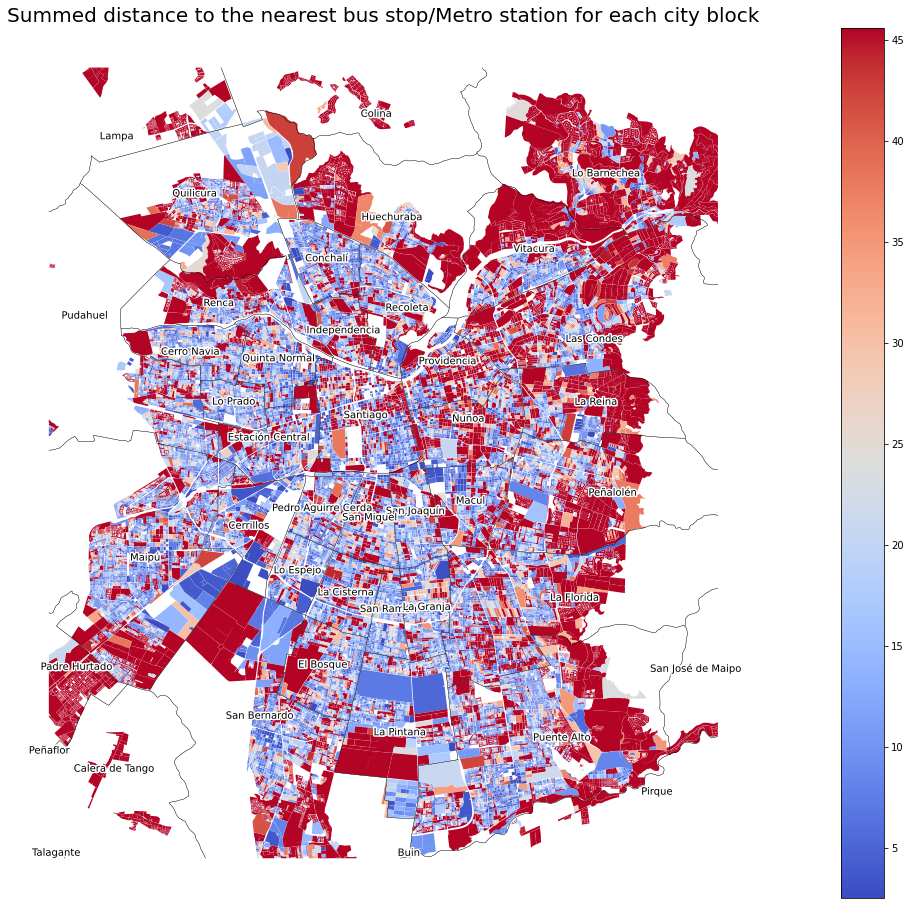

In [22]:
var_name = 'summed_distance_nearest'
vmin = blocks_transit_f[var_name].quantile(0.05)
vmax = blocks_transit_f[var_name].quantile(0.90)

ax = plot_blocks(blocks_transit_f, var_name, vmin, vmax, cmap='coolwarm')
ax = plot_communes(communes, annotate_communes=True, linewidth=0.3, ax=ax)
title = f"Summed distance to the nearest bus stop/Metro station for each city block"
ax.set_title(title, {'fontsize': 20, 'color': 'black'})
plt.show()

### 6.4 Average number of unique bus routes/Metro lines that run through stops within 900m of the person
As a proxy for "well-connectedness" (which tries to be a measure for quality of service), I included the average number of unique bus routes or Metro lines that a person can access within 900m (which, in a straight line, is a 15-minute walk), restricting to the nearest 10 stops/stations.  
On the average city block, a person can access 7.8 different bus routes/Metro lines. However, this is not uniformly distributed across the city. The bottom 1% of blocks have access to 0 routes or lines and the bottom 5% to only 2, while the top 10% have access to 13.35 or more buses or lines. It should be noted that (as expected from the other maps) the outskirts of the city are the worst connectivity.

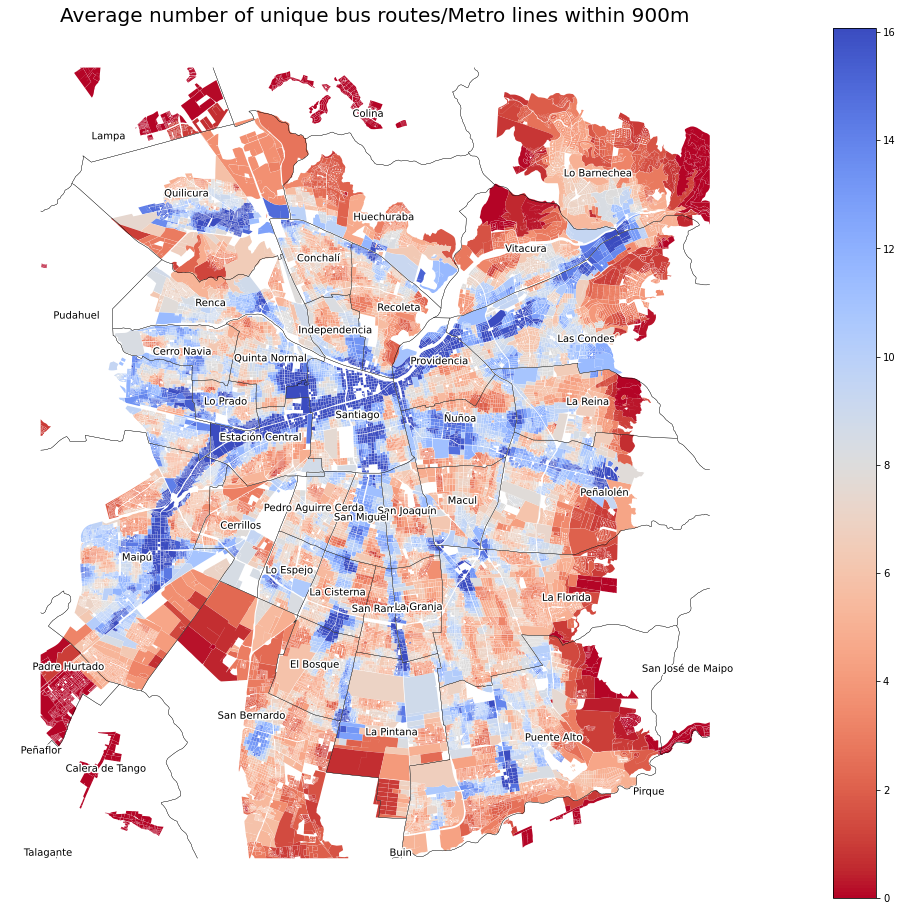

In [28]:
var_name = 'mean_n_routes_close'
vmin = blocks_transit_f[var_name].quantile(0)
vmax = blocks_transit_f[var_name].quantile(0.95)

ax = plot_blocks(blocks_transit_f, var_name, vmin, vmax, cmap='coolwarm_r')
ax = plot_communes(communes, annotate_communes=True, linewidth=0.3, ax=ax)
title = f"Average number of unique bus routes/Metro lines within {int(DIST_MAX*1000)}m"
ax.set_title(title, {'fontsize': 20, 'color': 'black'})
plt.show()

Average: 7.801
Bottom 1%: 0.0
Bottom 5%: 2.009
Top 10%: 13.36


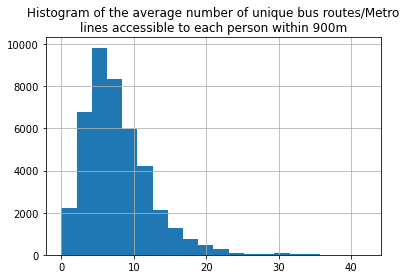

In [192]:
mean = blocks_transit_f.mean_n_routes_close.mean()
q_01 = blocks_transit_f.mean_n_routes_close.quantile(0.01)
q_05 = blocks_transit_f.mean_n_routes_close.quantile(0.05)
q_90 = blocks_transit_f.mean_n_routes_close.quantile(0.90)
print(f"Average: {mean:.4}\nBottom 1%: {q_01:.4}\nBottom 5%: {q_05:.4}\nTop 10%: {q_90:.4}")

blocks_transit_f.mean_n_routes_close.hist(bins=20)
plt.title("Histogram of the average number of unique bus routes/Metro\nlines accessible to each person within 900m")
plt.show()

### 6.5 Average number of buses/trains that run through stops within 900m of the person on a working day
Similarly to the previous variable, the average number of buses/trains also tries to be a proxy of the quality of service.  
Comparing with the last map there are not many marked differences.

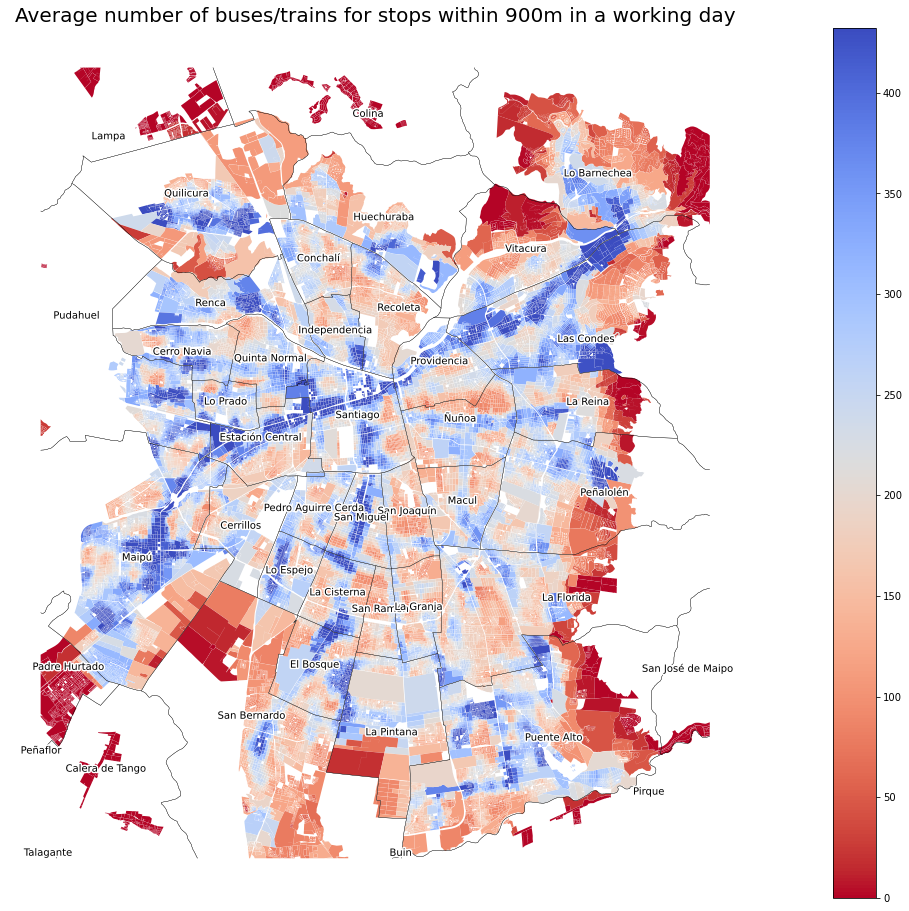

In [24]:
var_name = 'mean_n_buses_close'
vmin = blocks_transit_f[var_name].quantile(0)
vmax = blocks_transit_f[var_name].quantile(0.95)

ax = plot_blocks(blocks_transit_f, var_name, vmin, vmax, cmap='coolwarm_r')
ax = plot_communes(communes, annotate_communes=True, linewidth=0.3, ax=ax)
title = f"Average number of buses/trains for stops within {int(DIST_MAX*1000)}m in a working day"
ax.set_title(title, {'fontsize': 20, 'color': 'black'})
plt.show()

## 7. Discussion

### 7.1 Limitations

- This analysis uses a direct path to calculate the distance between each point and its nearby stops, but in reality, this path might be different.
- Because of the lack of a granular dataset, I simulated the position of each person in the city inside each city block using a uniform distribution. This is an assumption and might not reflect correctly the real world. As mitigation, I ran multiple simulations and obtained almost the same results every time.

## 8. Conclusion

This analysis has shown that the response to the question **Who is being left out by public transport?** depends on what we understand by *being left out*. If we consider being *left out* as having a high distance to the nearest bus stop/Metro station, we see that the outskirts of the city and some dispersed low-connectivity patches are the most underserved. 
If we now consider *left out* as having a low number of buses or routes passing through the nearest stops, then the only areas well-served are the ones near main roads.  
However, despite the differences in the results obtained by each metric, there is one group that is constantly shown as having the worst quality and accessibility: the outskirts of the city.

___

## A. Appendix

### A.1 Location of every bus stop/Metro station

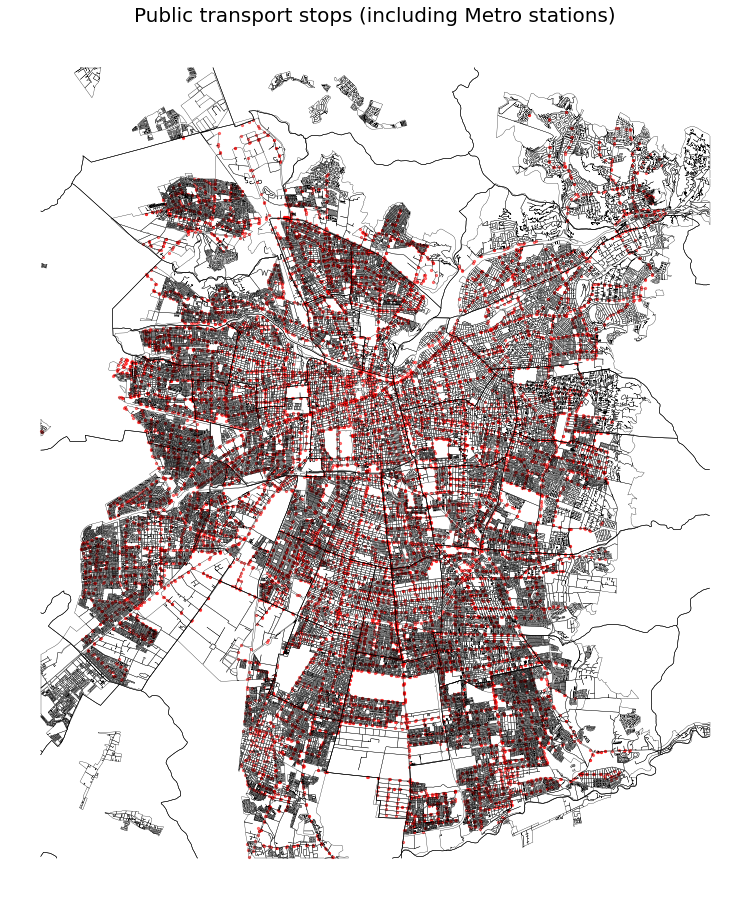

In [30]:
ax = plot_blocks(blocks, color='black', plot_only_borders=True, linewidth=0.3, cmap=None)
ax = plot_communes(communes, annotate_communes=False, color="black", linewidth=0.5, ax=ax)
clipped_stops = gpd.clip(stops, box_gdf)
clipped_stops.plot(ax=ax, markersize=5, color='red', alpha=0.5)
title = "Public transport stops (including Metro stations)"
ax.set_title(title, {'fontsize': 20, 'color': 'black'})
plt.show()

### A.2 Alternative plot style

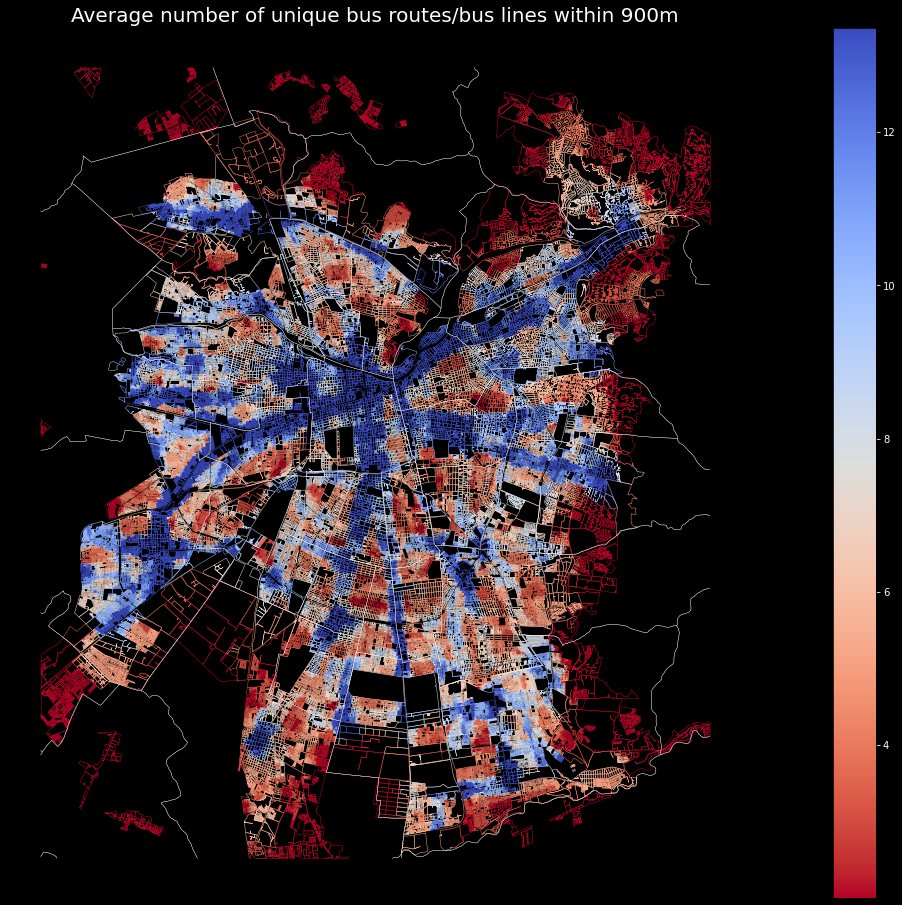

In [26]:
var_name = 'mean_n_routes_close'
vmin = blocks_transit_f[var_name].quantile(0.05)
vmax = blocks_transit_f[var_name].quantile(0.90)
ax = plot_blocks(blocks_transit_f, var_name, vmin, vmax, plot_only_borders=True, background_color='black', cbar_colors='white', cmap='coolwarm_r')
ax = plot_communes(communes, annotate_communes=False, color="white", linewidth=0.3, ax=ax)
title = f"Average number of unique bus routes/bus lines within {int(DIST_MAX*1000)}m"
ax.set_title(title, {'fontsize': 20, 'color': 'white'})
plt.show()

### A.3 Population density

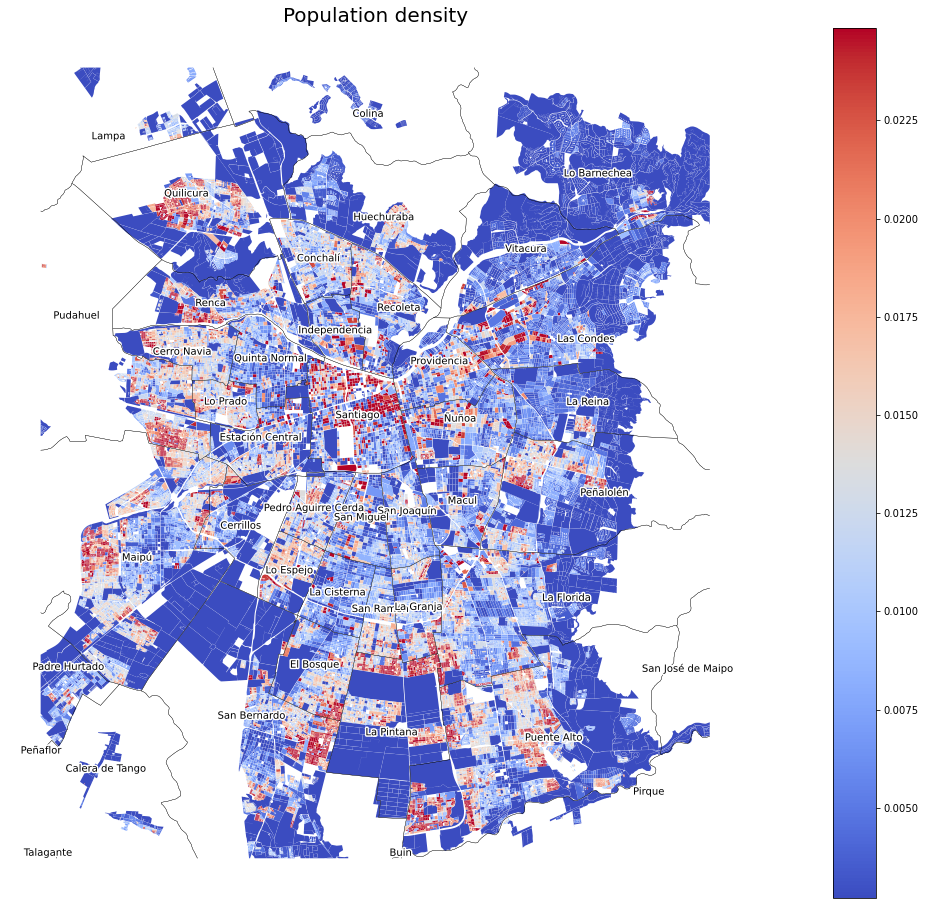

In [27]:
var_name = 'density'
vmin = blocks_transit_f[var_name].quantile(0.05)
vmax = blocks_transit_f[var_name].quantile(0.90)

ax = plot_blocks(blocks_transit_f, var_name, vmin, vmax, cmap='coolwarm')
ax = plot_communes(communes, annotate_communes=True, linewidth=0.3, ax=ax)
title = f"Population density"
ax.set_title(title, {'fontsize': 20, 'color': 'black'})
plt.show()